In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
def load_plot_archive(path):
    """
    Loads the data from the experiment into RAM
    
    returns:
        - keys df
        - df
    """
    file_path = [path]

    for path in file_path:
        with open(path, 'rb') as f:
            data = np.load(f, allow_pickle=True)[()]
    
    keys = data.keys()
    return keys, data

In [3]:
def create_df_list(keys, df):
    """
    Creates a list of dataframes
    
    Returns:
        - df list
    """

    df_list = []
    for key in keys:
#         print(df[key])
        df_list.append(df[key])
    return df_list

In [4]:
def get_outbreaks(data, threshold=50):
    """
    Calculates the outbreaks from the actives data.

    Returns:
        - An array with the outbreak peak sizes.
        - An array with the outbreak durations.
    """
    outbreak_peaks = []
    outbreak_widths = []
    counting = False
    current_peak = 0
    start = 0

    for i in range(len(data)):

        if data[i] >= threshold and not counting:
            counting = True
            if current_peak < data[i]:
                current_peak = data[i]
            start = i

        elif data[i] >= threshold and counting:
            if current_peak < data[i]:
                current_peak = data[i]

        elif data[i] < threshold and counting:
            outbreak_peaks.append(current_peak)
            outbreak_widths.append(i-start)
            current_peak = 0
            counting = False

    # Capture cases where timeline ends in an outbreak.
    # Obviously skewers data, but preferable over 0 or infinite outbreaks.
    if not outbreak_peaks and counting:
        outbreak_peaks.append(current_peak)
        outbreak_widths.append(len(data))
    elif not outbreak_peaks and not counting:
        outbreak_peaks.append(0)
        outbreak_widths.append(0)

    return outbreak_peaks, outbreak_widths, list(range(len(outbreak_peaks)))

In [5]:
def create_peakduration_df(name, data):
    """
    Creates a dataframe of the data

    Returns:
        - Pandas.DataFrame Object 
        - list of outbreaks per run
    """

    total_peaks = []
    total_durations = []
    total_outbreak_numbers = []
    average_outbreaks = []
    
    for df in df_list:
        peaks , durations, outbreak_numbers = get_outbreaks(df.ACTIVE)
        total_peaks += peaks
        total_durations += durations
        total_outbreak_numbers += outbreak_numbers
        average_outbreaks.append(len(durations))

    df = pd.DataFrame(data={'PeakHeight': total_peaks, 
                            'PeakDuration': total_durations, 
                            'OutbreakNumber': total_outbreak_numbers})
    df["Network"] = name
    
    outbreaks_df = pd.DataFrame(data={'OutbreaksPerRun': average_outbreaks})
    outbreaks_df["Network"] = name
    
    return df, outbreaks_df

In [6]:
def read_filenames(directory):
    """
    Reads the different filenames of a directory
    
    returns:
        - filenames
    """    
    return [directory + name for name in os.listdir(directory)]

In [7]:
def drop_rows_df(df, columnname, condition):
    """
    Drops rows based on a condition
    
    returns:
        - dataframe
    """
    return df[df[columnname] != condition]

In [8]:
path = 'data/'
filenames = read_filenames(path)
names = [file.split('_')[5] for file in filenames]

full_df = pd.DataFrame()
full_outbreaks_df = pd.DataFrame()

for index in range(len(filenames)):
    
    keys, total_file_df = load_plot_archive(filenames[index])
    df_list = create_df_list(keys, total_file_df)
    df_plot, df_outbreaks_per_run = create_peakduration_df(names[index], df_list)
    full_df = pd.concat([full_df, df_plot])
    full_outbreaks_df = pd.concat([full_outbreaks_df, df_outbreaks_per_run])

# full_df = drop_rows_df(full_df, 'PeakDuration', 401)


In [9]:
temp = drop_rows_df(df_without_1, 'Network', 'BARABASI-ALBERT-influencer')
sns.displot(temp, x="PeakHeight", hue='Network', fill=True, kind='kde')
plt.savefig('WithoutRemoveInfluencerDensity')
sns.displot(temp, x='PeakDuration', hue='Network', fill=True, kind='kde')

NameError: name 'df_without_1' is not defined

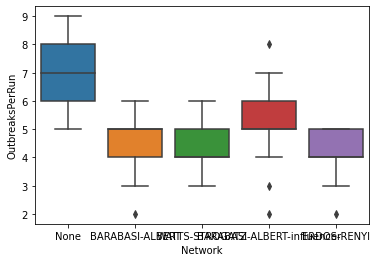

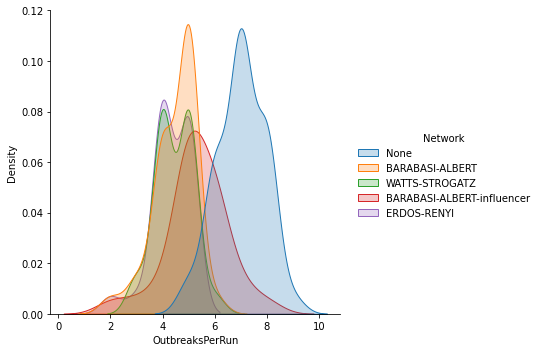

In [15]:
full_outbreaks_df
full_outbreaks_df = drop_rows_df(full_outbreaks_df, 'OutbreaksPerRun', 1)
sns.boxplot(x='Network', y='OutbreaksPerRun', data=full_outbreaks_df)
sns.displot(full_outbreaks_df, x="OutbreaksPerRun", hue='Network', fill=True, kind='kde')

In [ ]:
sns.scatterplot(data=full_df, x="PeakDuration", y="PeakHeight", hue="Network")

In [ ]:
sns.boxplot(x='Network', y='PeakDuration', data=full_df)
plt.show()
sns.boxplot(x='Network', y='PeakHeight', data=full_df)

In [ ]:
full_df
df_without_1 = drop_rows_df(full_df, 'OutbreakNumber', 0)

# full_df = drop_rows_df(full_df, 'PeakDuration', 401)

In [ ]:
sns.displot(df_without_1, x="PeakHeight", hue='Network', fill=True, kind='kde')
plt.savefig('withoud_bimodal.png')

In [ ]:
only2df = drop_rows_df(full_df, 'PeakDuration', 401)
only2df = drop_rows_df(only2df, 'Network', 'WATTS-STROGATZ')
only2df = drop_rows_df(only2df, 'Network', 'ERDOS-RENYI')
only2df = drop_rows_df(only2df, 'Network', 'None')
only2df = drop_rows_df(only2df, 'OutbreakNumber', 0)

sns.boxplot(x='Network', y='PeakHeight', data=only2df)
plt.show()
sns.boxplot(x='Network', y='PeakDuration', data=only2df)
sns.displot(only2df, x="PeakHeight", hue='Network', fill=True, kind='kde')
plt.savefig('only2density.png')
